# LagrangeBench Datasets

This is an overview of the introduced datasets. We show:

- Dataset animations.
- Evaluation of physical properties.

The structure of all datasets is the same and consists of four files:
- `metadata.json` - the data needed to set up the numerical solver and simulate trajectories
- `train.h5` - training set
- `valid.h5` - validation set
- `test.h5` - test set

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
from jax import vmap
from jax_md import space
import matplotlib.pyplot as plt

import lagrangebench

plt.rcParams.update({'font.size': 10})

2023-10-24 20:16:52.116209: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:276] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
CUDA backend failed to initialize: FAILED_PRECONDITION: No visible GPU devices. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Dataset animations

We animate a few consecutive frames from our datasets using [ParaView](https://www.paraview.org/) and color the particles by the magnitude of their velocity.

- Reverse Poiseuille Flow

    ![rpf2d.gif](https://s11.gifyu.com/images/Sce92.gif)
    ![rpf3d.gif](https://s11.gifyu.com/images/Sce3X.gif)

- Taylor Green Vortex

    ![tgv2d.gif](https://s11.gifyu.com/images/Sce9b.gif)
    ![tgv3d.gif](https://s11.gifyu.com/images/Sce9z.gif)

- Lid-Driven Cavity

    ![ldc2d.gif](https://s11.gifyu.com/images/Sce9S.gif)
    ![ldc3d.gif](https://s11.gifyu.com/images/Sce3e.gif)

- Dam Break

    ![dam2d.gif](https://s11.gifyu.com/images/SceKB.gif)


## Dataset shapes

Short script to check the shapes of the raw validation datasets.

If you haven't downloaded the datasets yet, you can do so by running this script from the root of the repository:

```bash
bash download_data.sh all notebooks/datasets/
```

In [3]:
import os.path as osp
import h5py

# the datasets are stored in the following directories, whose names follow the convention:
# {dim}_{case}_{num_particles_max}_{num_steps}every{sampling_rate}
# dim - dimension. One of {2D|3D}.
# case - simulation case. One of {TGV|RPF|LDC|DAM}.
# num_particles_max - maximum number of particles in the dataset.
# num_steps - number of position frames in the training split of the dataset.
# sampling_rate - sampling_rate=100 means that the position frames correspond to every
#     100th SPH simulation step.
path = [
    "2D_TGV_2500_10kevery100",
    "2D_RPF_3200_20kevery100",
    "2D_LDC_2708_10kevery100",
    "2D_DAM_5740_20kevery100",
    "3D_TGV_8000_10kevery100",        
    "3D_RPF_8000_10kevery100",
    "3D_LDC_8160_10kevery100",
]

# 6 history positions (5 past velocities) + 20-step rollout
valid_seq_length = 6 + 20  # during validation and inference
dataset_root = "datasets/"
split = "valid.h5"

for p in path:
    p = osp.join(dataset_root, p, split)
    with h5py.File(p, "r") as f:
        pos_shape =  f["00000/position"].shape
        split_into = pos_shape[0]//valid_seq_length
        num_trajs = len(list(f.keys()))
        print(f"{p[9:]}, traj_shape= {str(pos_shape):<20}, "
              f"split_valid_traj_into_n= {split_into:<5}, "
              f"num_trajs: {num_trajs:<5}, "
              f"eval_n_trajs_infer: {split_into * num_trajs}")

2D_TGV_2500_10kevery100/valid.h5, traj_shape= (126, 2500, 2)      , split_valid_traj_into_n= 4    , num_trajs: 50   , eval_n_trajs_infer: 200
2D_RPF_3200_20kevery100/valid.h5, traj_shape= (10001, 3200, 2)    , split_valid_traj_into_n= 384  , num_trajs: 1    , eval_n_trajs_infer: 384
2D_LDC_2708_10kevery100/valid.h5, traj_shape= (5001, 2708, 2)     , split_valid_traj_into_n= 192  , num_trajs: 1    , eval_n_trajs_infer: 192
2D_DAM_5740_20kevery100/valid.h5, traj_shape= (401, 5740, 2)      , split_valid_traj_into_n= 15   , num_trajs: 25   , eval_n_trajs_infer: 375
3D_TGV_8000_10kevery100/valid.h5, traj_shape= (61, 8000, 3)       , split_valid_traj_into_n= 2    , num_trajs: 100  , eval_n_trajs_infer: 200
3D_RPF_8000_10kevery100/valid.h5, traj_shape= (5001, 8000, 3)     , split_valid_traj_into_n= 192  , num_trajs: 1    , eval_n_trajs_infer: 192
3D_LDC_8160_10kevery100/valid.h5, traj_shape= (5001, 8160, 3)     , split_valid_traj_into_n= 192  , num_trajs: 1    , eval_n_trajs_infer: 192


## Evaluation of physical properties

Here we focus on the kinetic energy as a measure of physical behaviour. We distinguish two cases:

1. Statistically stationary $E_{kin}$ (RPF and LDC) - the kinetic energy oscillates around an equilibrium value, and the oscillations are because of the finite number of particle used for the discretization.
2. Variable $E_{kin}$ (TGV, DAM) - In the TGV example it decays due to viscous interactions and in dam break it first increases by transfer of potential to kinetic energy, but then also decays due to viscosity.

In [4]:
# utils

def compute_kinetic_energy(metadata, traj):
    bounds = np.array(metadata["bounds"])
    displacement_fn, _ = space.periodic(side=bounds[:,1])
    displ_vmap = vmap(displacement_fn, (0, 0))
    displ_dvmap = vmap(displ_vmap, (0, 0))

    displacement = displ_dvmap(traj[:,1:], traj[:, :-1])
    vel = displacement / (metadata["dt"] * metadata["write_every"])
    vel = np.asarray(vel) # shape: (num_particles, num_steps, dim)
    square_absolute_velocity = (vel**2).sum(axis=2) # shape: (num_particles, num_steps)
    e_kin = 0.5 * square_absolute_velocity.mean(axis=(0,)) # shape: (num_steps,)
    return e_kin

def plt_e_kin(dataset_path, seq_len, e_kin_ref=None):
    dim, name, _, _ = dataset_path.split('/')[1].split('_')
    
    dataset = lagrangebench.data.H5Dataset(
        "valid", 
        dataset_path=dataset_path,
        input_seq_length=seq_len,
        extra_seq_length=1,
    )
    traj, _ = dataset[0]
    e_kin = compute_kinetic_energy(dataset.metadata, traj)
        
    plt.figure(figsize=(8,4))
    plt.plot(np.arange(len(e_kin)) + 0.5, e_kin, 'xb', label='dataset')
    
    if e_kin_ref is not None:
        plt.plot(e_kin_ref, 'r', label='reference')
    
    plt.legend() 
    plt.grid()
    plt.title(f"{dim} {name}")
    plt.xlabel('step')
    plt.ylabel('Ekin')

### RPF and LDC

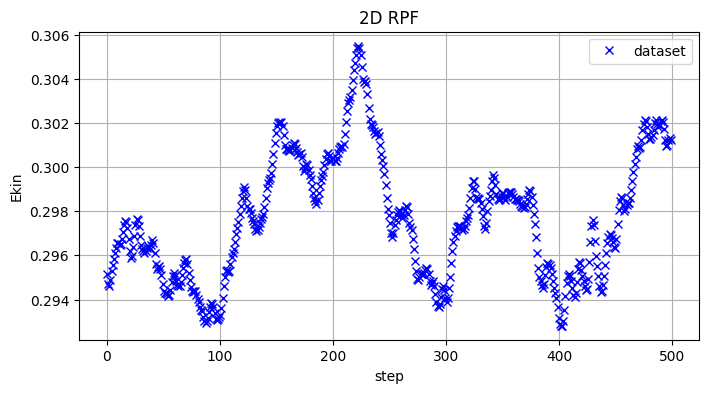

In [5]:
plt_e_kin("datasets/2D_RPF_3200_20kevery100", 500)

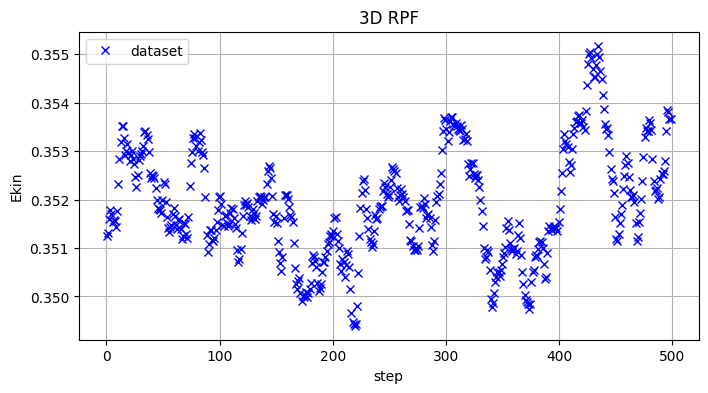

In [6]:
plt_e_kin("datasets/3D_RPF_8000_10kevery100", 500)

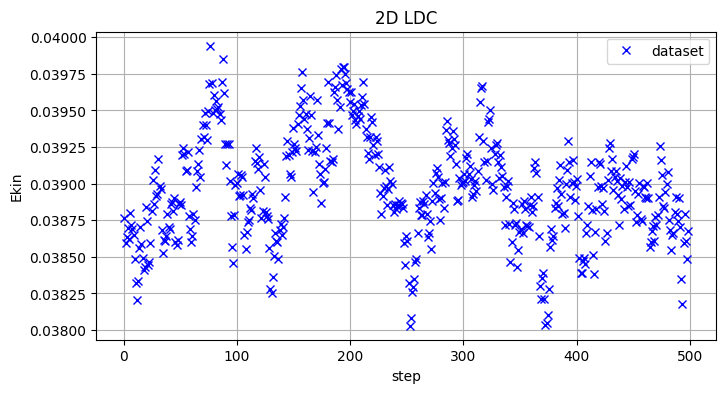

In [7]:
plt_e_kin("datasets/2D_LDC_2708_10kevery100", 500)

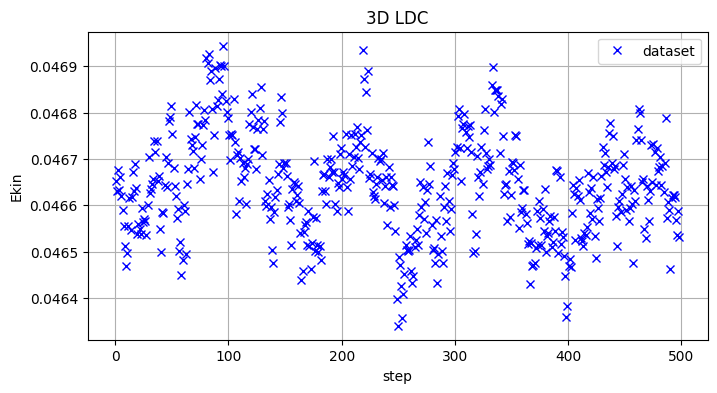

In [8]:
plt_e_kin("datasets/3D_LDC_8160_10kevery100", 500)

### DAM

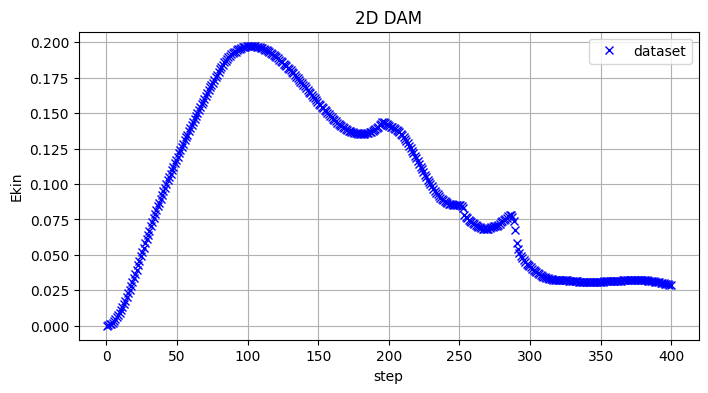

In [9]:
plt_e_kin("datasets/2D_DAM_5740_20kevery100", 400)

### 2D TGV

The two dimensional Taylor-Green vortex has an analytical solution as outlined in [1]. Here, we compare this solution of the kinetic energy with the kinetic enery in one of our dataset trajectories.

[1] - Adami et al., [A transport-velocity formulation for smoothed particle hydrodynamics](https://www.sciencedirect.com/science/article/abs/pii/S002199911300096X), 2013

In [10]:
dataset_path = "datasets/2D_TGV_2500_10kevery100"
dataset = lagrangebench.data.H5Dataset(
    "valid", 
    dataset_path=dataset_path,
    extra_seq_length=1,
)

dt_dataset = (dataset.metadata['dt'] * dataset.metadata['write_every'])
len_traj = 1 + dataset.metadata['t_end'] / dt_dataset
t = np.linspace(0, dataset.metadata['t_end'], int(len_traj)) # physical time axis

rho_ref = 1. # reference density
u_ref = 1. # reference velocity, i.e. u_max at t=0
L_ref = 1. # reference length, i.e. domain size
eta = dataset.metadata['viscosity'] # viscosity
Re = rho_ref * u_ref * L_ref / eta # Reynolds number
slope_u_max = - 8 * np.pi ** 2 / Re # analytical decay rate of max velocity
# factor 0.25 = int(int((sin(2 pi x) cos(2 pi y))^2, x from 0 to 1), y from 0 to 1)
e_kin_theory = 0.25 * np.exp(2 * slope_u_max * t) # analytical kinetic energy evolution

In the above we used information from the `dataset.metadata` which is the content of a metadata file associated with each of our datasets. The metadata file for 2D TGV looks like this:

In [11]:
dataset.metadata

{'case': 'TGV',
 'solver': 'SPH',
 'density_evolution': False,
 'dim': 2,
 'dx': 0.02,
 'dt': 0.0004,
 't_end': 5.0,
 'viscosity': 0.01,
 'p_bg_factor': 0.0,
 'g_ext_magnitude': 0.0,
 'artificial_alpha': 0.0,
 'free_slip': False,
 'write_every': 100,
 'is_bc_trick': False,
 'sequence_length_train': 126,
 'num_trajs_train': 100,
 'sequence_length_test': 126,
 'num_trajs_test': 50,
 'num_particles_max': 2500,
 'periodic_boundary_conditions': [True, True, True],
 'bounds': [[0.0, 1.0], [0.0, 1.0]],
 'default_connectivity_radius': 0.029,
 'vel_mean': [2.9928384037702926e-07, 5.485588872033986e-07],
 'vel_std': [0.006356782279908657, 0.006356848403811455],
 'acc_mean': [1.1536379524465599e-14, -1.9131170172353995e-13],
 'acc_std': [0.0008755344315432012, 0.0008755328599363565]}

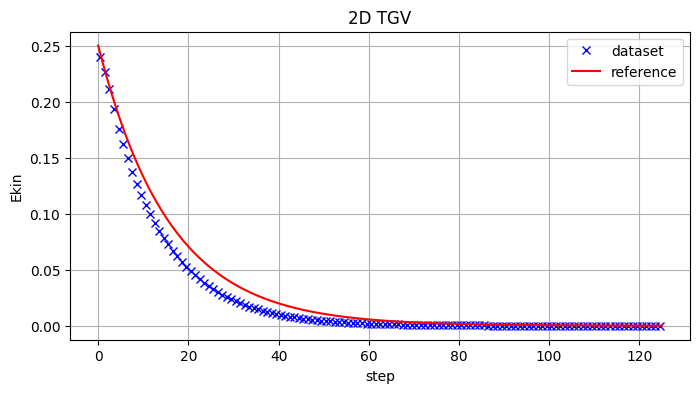

In [12]:
plt_e_kin(dataset_path, 125, e_kin_theory)

We don't perfectly solve the 2D TGV, but this behaviour is a known limitation of purely Lagrangian SPH, as shown in [1]. We remind the reader that we restrict ourselves to purely Lagrangian schemes so that we are able to recover the velocity of particles by computing the difference between positions, something that is not valid with improved semi-Lagrangian SPH schemes.

### 3D TGV

The three dimensional Taylor Green system at Re=50 does not have an analytical solution, but we run a high resolution reference simulation with the [JAX-Fluids](https://github.com/tumaer/JAXFLUIDS) solver and store the values of the kinetic energy at seconds [0, 0.5, 1, 1.5, ... 10]. 

Here, we again don't perfectly recover the true solution, but the initial rapid drop in kinetic energy on the 3D TGV is also a documented limitatation of purely Lagrangian SPH, see [2]. And yet we are rather close to the reference.

[2] - Adami et al., [Simulating three-dimensional turbulence with SPH](https://mediatum.ub.tum.de/doc/1360487/978874575863.pdf), 2012

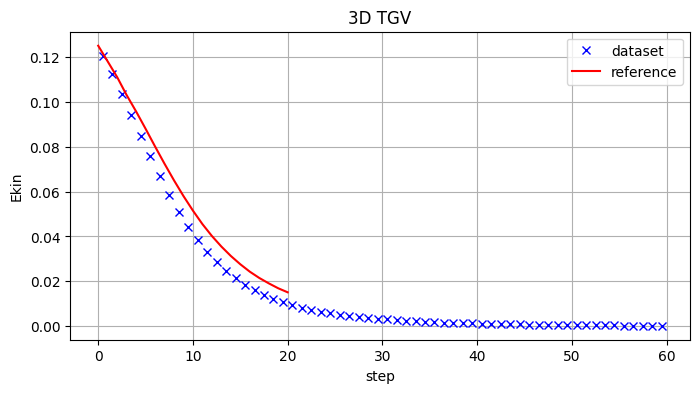

In [13]:
e_kin_ref = 0.001 * np.array([
    125, 118, 111, 103, 95.7, 88.0, 80.1, 72.4, 65, 58, 51.5,
    45.5, 40.2, 35.5, 31.3, 27.6, 24.3, 21.5, 19.1, 16.9, 15.1
])
plt_e_kin("datasets/3D_TGV_8000_10kevery100", 59, e_kin_ref)